In [ ]:
with open("svante.txt") as f:
    text = f.read()
svante = text.split(" ")

with open("arctic.txt") as f:
    text = f.read()
arctic = text.split(" ")

In [ ]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [ ]:
# Run embedding on multiple threads using multiprocessing
def create_embedding_parallel(chunks: list[str], num_threads=4):
    import multiprocessing
    from concurrent.futures import ThreadPoolExecutor

    def create_embeddings(chunk: list[str]):
        embeddings = client.embeddings.create(input = chunk, model = "text-embedding-3-large", dimensions=256, timeout=5)
        return [d.embedding for d in embeddings.data]

    def create_chunks(lst, num_chunks):
        return [lst[i:i + num_chunks] for i in range(0, len(lst), num_chunks)]

    # Split chinks into N lists of chunks
    chunks_of_chunks = create_chunks(chunks, num_threads)
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        embeddings = list(executor.map(create_embeddings, chunks_of_chunks))
    # Now we have a list of list of embeddings. Flatten out
    all_embeddings = []
    for e in embeddings:
        all_embeddings.extend(e)
    return all_embeddings


In [ ]:
from tqdm import tqdm

def create_all_embeddings(words):        
    chunk_size = 25
    chunk_stride = 1
    # Split words into chunks of size chunk_size and stride chunk_stride
    chunks = [words[i:i+chunk_size] for i in range(0, len(words), chunk_stride)]

    # Loop over all chunks and generate embeddings
    embeddings = []
    chunks_as_str = [" ".join(chunk) for chunk in chunks]
    embeddings = create_embedding_parallel(chunks_as_str, num_threads=10)
    # for chunk in tqdm(chunks):
    #     chunk_as_str = " ".join(chunk)
    #     embedding = client.embeddings.create(input = chunk_as_str, model = "text-embedding-3-large", dimensions=256, timeout=5)
    #     embeddings.append(embedding.data[0].embedding)
    return chunks, embeddings

In [ ]:
#chunks, embeddings = create_all_embeddings(svante)

In [ ]:
import numpy as np
def autocorr(embeddings):
    corr_values = np.zeros(len(embeddings))
    counts = np.zeros(len(embeddings))
    for i in range(len(embeddings)):
        for j in range(i, len(embeddings)):
            corr_values[j-i] += np.dot(embeddings[i], embeddings[j])
            counts[j-i] += 1

    corr_values /= counts
    return corr_values

In [ ]:
svante_chunks, svante_embeddings = create_all_embeddings(svante)
svante_corr = autocorr(svante_embeddings)

import matplotlib.pyplot as plt
arctic_chunks, arctic_embeddings = create_all_embeddings(arctic)
arctic_corr = autocorr(arctic_embeddings)

plt.plot(arctic_corr[0:50], label='arctic')
plt.plot(svante_corr[0:50], label='svante')
plt.legend()


In [60]:
def create_chunks(words, offset, min_chunk_size, max_chunk_size, chunk_stride):
    all_chunks = []
    for chunk_size in range(min_chunk_size, max_chunk_size+1, chunk_stride):
        chunk = []
        for i in range(chunk_size):
            chunk.append(words[offset+i])
        all_chunks.append(" ".join(chunk))
    return all_chunks

In [ ]:
words = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]
min_chunk_size = 2
chunk_stride = 1
max_chunk_size = 5
offset_stride = 3
for offset in range(0, len(words)-max_chunk_size+1, offset_stride):
    print("Starting on offset ", offset)
    stuff = create_chunks(words, offset, min_chunk_size, chunk_stride, max_chunk_size)
    for thing in stuff:
        display(thing)


In [58]:
svante[1]

'was'

In [72]:
def get_color_value(value, minValue, maxValue, cmap='viridis'):
    import matplotlib
    """Get color from colormap.

    Parameters
    -----------------
    :param value: Value used tpo get color from colormap
    :param minValue: Minimum value in colormap. Values below this value will saturate on the lower color of the colormap.
    :param maxValue: Maximum value in colormap. Values above this value will saturate on the upper color of the colormap.

    :returns: 4-vector containing colormap values. 

    This is useful if you are plotting data from several simulations, and want to color them based on some parameters changing between the simulations. For example, you may want the color to gradually change along a clormap as the temperature increases. 

    """
    diff = maxValue-minValue
    cmap = matplotlib.cm.get_cmap(cmap)
    rgba = cmap((value-minValue)/diff)
    return rgba

100%|██████████| 23/23 [00:16<00:00,  1.43it/s]


Text(0.5, 1.0, 'Chunk autocorrelation')

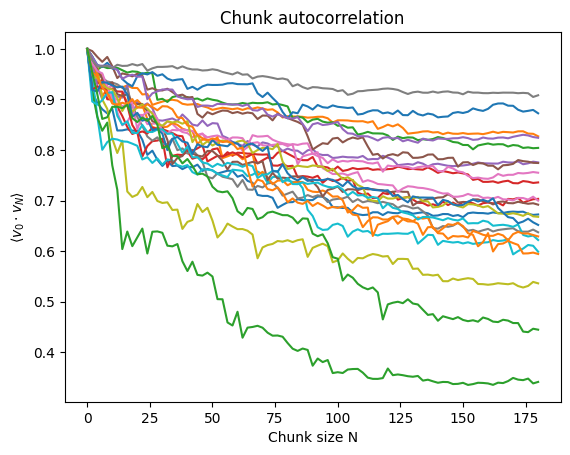

In [76]:
min_chunk_size = 20
max_chunk_size = 200
chunk_size_stride = 2
offset_stride = 100
max_offset = len(svante)-max_chunk_size+1

plt.figure()
for offset in tqdm(range(0, max_offset, offset_stride)):
    chunks = create_chunks(svante, offset, min_chunk_size, max_chunk_size, chunk_size_stride)
    embeddings = create_embedding_parallel(chunks, num_threads=10)
    x_values = [chunk_size_stride*i for i in range(len(embeddings))]
    y_values = []
    for embedding in embeddings:
        y_values.append(np.dot(embedding, embeddings[0]))
    plt.plot(x_values, y_values, label = f"offset {offset}")
plt.xlabel("Chunk size N")
plt.ylabel(r"$\langle v_0 \cdot v_N \rangle$")
plt.title("Chunk autocorrelation")
# plt.legend()